<a href="https://colab.research.google.com/github/brillync/AI/blob/main/Tomat_Vision_APP_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kampus Merdeka 6: IBM & Skilvul

## CAPSTONE PROJECT
## Kelompok: 31
## Anggota

*  Ahmad Syaefudin
*  Brilliani Yanuar Nurchasanah
*  Mishel Rinaldi
*  Natania Las Maritho
*  Salsabilla Laura Lanzari

# Problem Definition

##Topik: Tomato Image Classification

## Data yang akan dipakai
Tomato Dataset \\
https://www.kaggle.com/datasets/enalis/tomatoes-dataset \\
Deskripsi:
## Jenis Masalah Neural Network
Menggunakan metode Computer Vision (CV)
## Model
Menggunakan model Convolutional Neural Networks (CNN)

# Kode Program

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Import Packages

In [ ]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, MaxPooling2D, Dropout, Conv2D, Flatten
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping

## Get Data

In [ ]:
train_dir = '/content/drive/MyDrive/TomatVision/train'
valid_dir = '/content/drive/MyDrive/TomatVision/val'

In [ ]:
train_input_path, train_label = [], []
val_input_path, val_label = [], []

class_names = ['Ripe', 'Unripe', 'Damaged', 'Old']
class_labels = {name: idx for idx, name in enumerate(class_names)}

# Fungsi untuk mengumpulkan path dan label
def collect_data(folder_path, input_path, label):
    if not os.path.exists(folder_path):
        print(f"Direktori {folder_path} tidak ditemukan.")
        return
    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)
        if os.path.isdir(class_dir) and class_name in class_labels:
            for path in os.listdir(class_dir):
                file_path = os.path.join(class_dir, path)
                if os.path.isfile(file_path):
                    input_path.append(file_path)
                    label.append(class_labels[class_name])

collect_data(train_dir, train_input_path, train_label)
collect_data(valid_dir, val_input_path, val_label)

In [ ]:
for label, class_name in enumerate(class_names):
    print(f"Label {label}: {class_name}")

Label 0: Ripe
Label 1: Unripe
Label 2: Damaged
Label 3: Old


In [ ]:
# Membuat DataFrame dari data yang dikumpulkan
train_df = pd.DataFrame({'images': train_input_path, 'label': train_label})
val_df = pd.DataFrame({'images': val_input_path, 'label': val_label})

In [ ]:
print("Training DataFrame:   ")
train_df.head()

Training DataFrame:   


,images,label
0,/content/drive/MyDrive/TomatVision/train/Ripe/...,0
1,/content/drive/MyDrive/TomatVision/train/Ripe/...,0
2,/content/drive/MyDrive/TomatVision/train/Ripe/...,0
3,/content/drive/MyDrive/TomatVision/train/Ripe/...,0
4,/content/drive/MyDrive/TomatVision/train/Ripe/...,0


In [ ]:
train_df.shape

(6502, 2)

In [ ]:
print("Validation DataFrame: ")
val_df.head()

Validation DataFrame: 


,images,label
0,/content/drive/MyDrive/TomatVision/val/Damaged...,2
1,/content/drive/MyDrive/TomatVision/val/Damaged...,2
2,/content/drive/MyDrive/TomatVision/val/Damaged...,2
3,/content/drive/MyDrive/TomatVision/val/Damaged...,2
4,/content/drive/MyDrive/TomatVision/val/Damaged...,2


In [ ]:
val_df.shape

(725, 2)

## Data Exploration

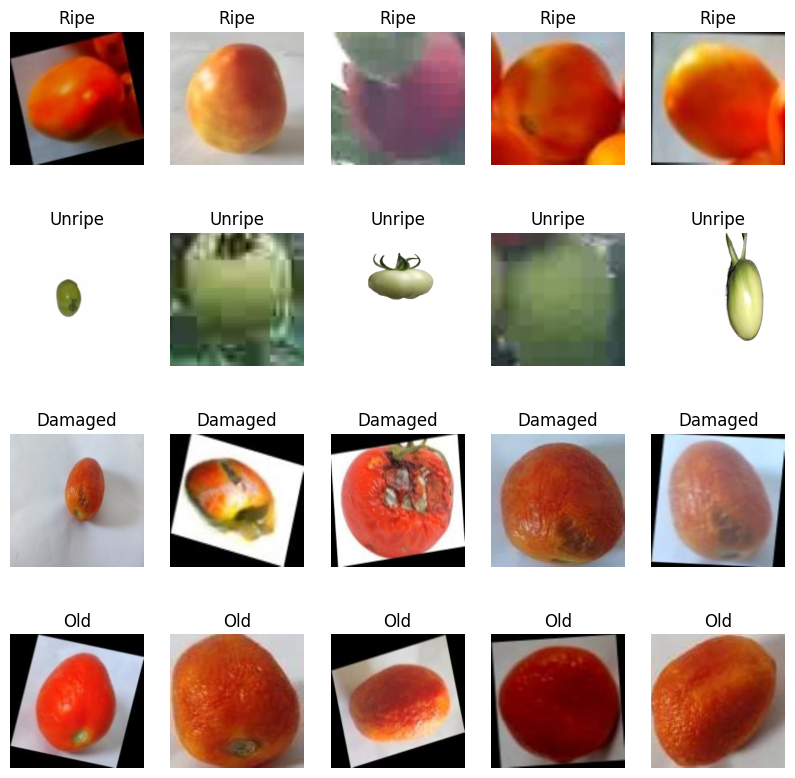

In [ ]:
def show_images(input_paths, labels, class_names, num_images=5, image_size=(10, 10)):
    plt.figure(figsize=(image_size[0], image_size[1]))
    for class_name in class_names:
        class_paths = [input_paths[i] for i in range(len(input_paths)) if labels[i] == class_labels[class_name]]
        for i, path in enumerate(class_paths[:num_images]):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(len(class_names), num_images, class_names.index(class_name) * num_images + i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(class_name)
    plt.show()

show_images(train_input_path, train_label, class_names)

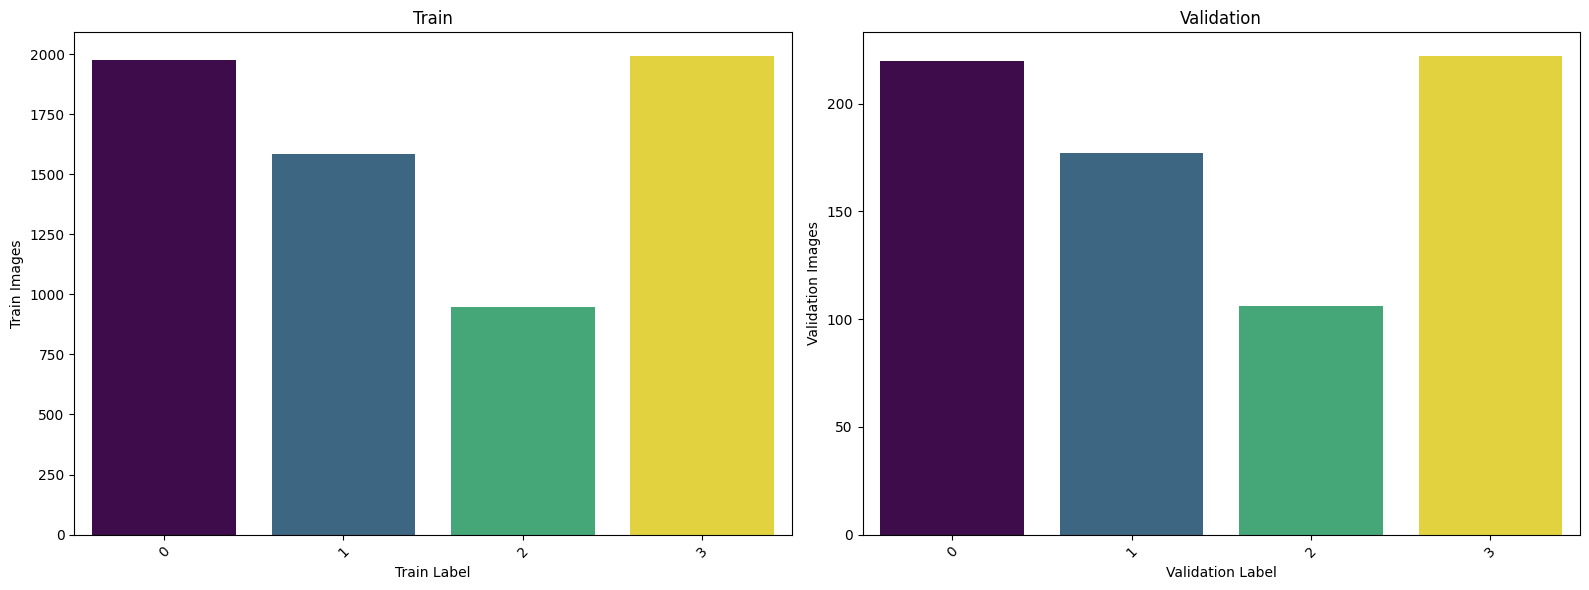

In [ ]:
def plotlabel_counts(label_data_train, label_data_val):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot untuk dataset pelatihan
    label_df_train = pd.DataFrame({'Label': label_data_train})
    label_counts_train = label_df_train['Label'].value_counts()
    sns.barplot(ax=axes[0], x=label_counts_train.index, y=label_counts_train.values, hue=label_counts_train.index,
                dodge=False, palette='viridis', legend=False)
    axes[0].set_xlabel('Train Label')
    axes[0].set_ylabel('Train Images')
    axes[0].set_title('Train')
    axes[0].tick_params(axis='x', rotation=45)

    # Plot untuk dataset validasi
    label_df_val = pd.DataFrame({'Label': label_data_val})
    label_counts_val = label_df_val['Label'].value_counts()
    sns.barplot(ax=axes[1], x=label_counts_val.index, y=label_counts_val.values, hue=label_counts_val.index,
                dodge=False, palette='viridis', legend=False)
    axes[1].set_xlabel('Validation Label')
    axes[1].set_ylabel('Validation Images')
    axes[1].set_title('Validation')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

plotlabel_counts(train_label, val_label)

## Data Prepocessing

Resampling

In [ ]:
from collections import Counter
from sklearn.utils import resample

def resample_train(input_paths, labels, num_samples=1000):
    resampled_input_paths_train, resampled_labels_train = [], []

    for label in set(labels):
        label_indices = [i for i, lbl in enumerate(labels) if lbl == label]
        label_input_paths = [input_paths[i] for i in label_indices]

        # Resampling untuk data train
        train_resampled = resample(label_input_paths,
                                   replace=True,
                                   n_samples=num_samples,
                                   random_state=42)

        resampled_input_paths_train.extend(train_resampled)
        resampled_labels_train.extend([label] * num_samples)

    return resampled_input_paths_train, resampled_labels_train

In [ ]:
def resample_val(input_paths, labels, num_samples=250):
    resampled_input_paths_val, resampled_labels_val = [], []

    for label in set(labels):
        label_indices = [i for i, lbl in enumerate(labels) if lbl == label]
        label_input_paths = [input_paths[i] for i in label_indices]

        # Resampling untuk data val
        val_resampled = resample(label_input_paths,
                                 replace=True,
                                 n_samples=num_samples,
                                 random_state=42)

        resampled_input_paths_val.extend(val_resampled)
        resampled_labels_val.extend([label] * num_samples)

    return resampled_input_paths_val, resampled_labels_val

In [ ]:
# Memanggil fungsi resample_train untuk dataset pelatihan
train_input_path2, train_label2 = resample_train(train_input_path, train_label)

# Memanggil fungsi resample_val untuk dataset validasi
val_input_path2, val_label2 = resample_val(val_input_path, val_label)

In [ ]:
print("Jumlah sampel train per label setelah resampling:", Counter(train_label2))
print("Jumlah sampel val per label setelah resampling:", Counter(val_label2))

Jumlah sampel train per label setelah resampling: Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000})
Jumlah sampel val per label setelah resampling: Counter({0: 250, 1: 250, 2: 250, 3: 250})


In [ ]:
# membuat DataFrame
train_df = pd.DataFrame({'images': train_input_path2, 'label': train_label2})
val_df = pd.DataFrame({'images': val_input_path2, 'label': val_label2})

Define Image Size

In [ ]:
img_width, img_height, channel = (224, 224, 3)

## Data Augmentation

In [ ]:
# Konversi tipe data kolom 'label' menjadi string
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

# Melakukan Data Generator pada train dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2
)

train_data = train_datagen.flow_from_dataframe(
    train_df,
    x_col='images',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

# Melakukan Data Generator pada validation dataset
valid_datagen = ImageDataGenerator(
    rescale=1./255
)

valid_data = valid_datagen.flow_from_dataframe(
    val_df,
    x_col='images',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

Found 4000 validated image filenames belonging to 4 classes.
Found 998 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="images". These filename(s) will be ignored.
  warnings.warn(


## Model Training

### Create Model

In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(
    input_shape=(img_width, img_height, 3),
    include_top=False,
    weights='imagenet'
)

for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [ ]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(64, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

### Compile Model

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics= [Recall(), Precision(), "accuracy"]
)

### Callback

In [ ]:
model_callback = EarlyStopping(
    monitor = 'loss',
    verbose = 1,
    mode = 'min',
    patience = 4
)

### Fit Model

In [ ]:
history = model.fit(
    train_data,
    validation_data = valid_data,
    epochs = 25,
    steps_per_epoch = 10, #usahakan step per epoch sesuai dengan hasil bagi dari jumlah training data dan batch size
    callbacks = [model_callback],
    verbose = 1
)

Epoch 1/25
10/10 [==============================] - 309s 32s/step - loss: 1.3692 - recall: 0.0063 - precision: 0.2222 - accuracy: 0.3406 - val_loss: 1.2026 - val_recall: 0.0671 - val_precision: 0.8272 - val_accuracy: 0.5601
Epoch 2/25
10/10 [==============================] - 198s 21s/step - loss: 1.0446 - recall: 0.2313 - precision: 0.7048 - accuracy: 0.5750 - val_loss: 0.8011 - val_recall: 0.5251 - val_precision: 0.7605 - val_accuracy: 0.6964
Epoch 3/25
10/10 [==============================] - 212s 22s/step - loss: 0.7798 - recall: 0.5875 - precision: 0.7373 - accuracy: 0.6938 - val_loss: 0.6223 - val_recall: 0.7315 - val_precision: 0.7783 - val_accuracy: 0.7575
Epoch 4/25
10/10 [==============================] - 208s 22s/step - loss: 0.6499 - recall: 0.7063 - precision: 0.7609 - accuracy: 0.7437 - val_loss: 0.4528 - val_recall: 0.7886 - val_precision: 0.8399 - val_accuracy: 0.8166
Epoch 5/25
10/10 [==============================] - 200s 21s/step - loss: 0.4700 - recall: 0.7844 - prec

## Model Evaluation

In [ ]:
model.evaluate(valid_data)

32/32 [==============================] - 112s 3s/step - loss: 0.3955 - recall: 0.8327 - precision: 0.8567 - accuracy: 0.8507


[0.395489901304245, 0.8326653242111206, 0.8567010164260864, 0.8507013916969299]

### Train and Val Plots

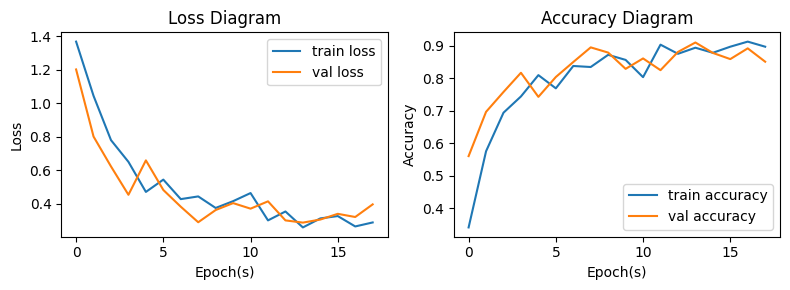

In [ ]:
plt.figure(figsize=(8, 3))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.epoch, history.history['loss'], label='train loss')
plt.plot(history.epoch, history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss Diagram')
plt.xlabel('Epoch(s)')
plt.ylabel('Loss')

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, history.history['accuracy'], label='train accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title('Accuracy Diagram')
plt.xlabel('Epoch(s)')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

### Confussion Matrix

In [ ]:
# Mendapatkan prediksi dari model terhadap data validasi
predictions = model.predict(valid_data)
y_pred = np.argmax(predictions, axis=1)

# Mendapatkan label sebenarnya dari data validasi
true_labels = valid_data.labels

# Membuat confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

akurasi tiap label (kalkulator manual)
*   ripe: 25,6%
*   unripe: 23,2%
*   damaged: 21,6%
*   old: 39,2%


## Save Model

In [ ]:
# model.save('finalModel.h5')

## Load Model

In [ ]:
# loaded_model = load_model('finalModel.h5')

In [ ]:
# from google.colab import files
# uploaded = files.upload()

# for fn in uploaded.keys():
#   # predicting images
#   img_path = '/content/' + fn
#   img = image.load_img(img_path, target_size=(224, 224));
#   img_array = image.img_to_array(img)
#   img_array = np.expand_dims(img_array, axis=0)

#   classes = loaded_model.predict(img_array/255);
#   for i, class_ in enumerate(classes[0]):
#       if class_ == classes[0].max():
#           if i == 0:
#               print("Busuk")
#           elif i == 1:
#               print("Keriput")
#           elif i == 2:
#               print("Masak")
#           else:
#               print("Mentah")